# Machine Learning Project 1

## Regression analysis and resampling methods

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from numpy.random import random, seed
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display


/tmp/ipykernel_97447/2424942843.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


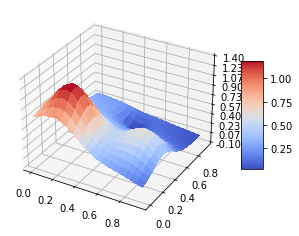

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [3]:
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


### Part a)

In [4]:
n_samples = 100

maxdegree = 5


np.random.seed(1)
x0 = np.random.rand(n_samples)
np.random.seed(2)
y0 = np.random.rand(n_samples)

x,y = np.meshgrid(x0,y0)

(10000, 21)
[ 0.07175909  0.15915887  0.04147802 ...  0.03765373 -0.07030416
 -0.31393387]
(10000,)
(21,)
0.012206268999883951
0.011980440394554802
0.8564319910816975
0.8627112515686368


/tmp/ipykernel_97447/3756839555.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


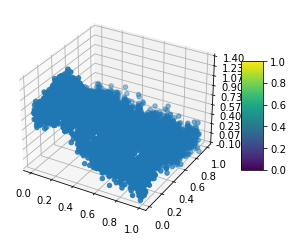

In [6]:
X = create_X(x,y,maxdegree)
print(X.shape)

noise = 0.1*np.random.randn(X.shape[0])
print(noise)

z = FrankeFunction(X[:,1],X[:,2]) + noise
print(z.shape)


X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)


beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train
z_train_tilde_ols = X_train@beta_ols
z_test_tilde_ols = X_test@beta_ols

mse_train = mean_squared_error(z_train,z_train_tilde_ols)
mse_test = mean_squared_error(z_test,z_test_tilde_ols)

r2_train = r2_score(z_train,z_train_tilde_ols)
r2_test = r2_score(z_test,z_test_tilde_ols)

print(mse_test)
print(mse_train)

print(r2_test)
print(r2_train)

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.scatter3D(X[:,1],X[:,2], z, cmap=cm.coolwarm)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [106]:
def bootstrap(data, M):
    global X
    t = np.zeros(M)
    n = len(data)
    MSE = np.zeros(M)
    # non-parametric bootstrap         
    for i in range(M):
        sequence = np.random.randint(0,n,n)
        X = X[sequence]
        z = data[sequence] 
        
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)


        beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train

        z_train_tilde_ols = X_train@beta_ols
        z_test_tilde_ols = X_test@beta_ols

        MSE[i] = mean_squared_error(z_test,z_test_tilde_ols)
        #mse_test = mean_squared_error(z_test,z_test_tilde_ols)
        
    # analysis    
    return MSE

In [115]:
mse_bs = bootstrap(z,100)
print(mse_bs)

[0.08474132 0.08212066 0.08451846 0.0872591  0.0896805  0.08876663
 0.0846933  0.08720183 0.08564113 0.08146539 0.08846661 0.09087931
 0.08898695 0.08557693 0.08455365 0.08866339 0.08670864 0.08543575
 0.08843461 0.08944772 0.0823282  0.08596928 0.08382987 0.09135208
 0.08696816 0.08412704 0.08489521 0.08928892 0.08914875 0.08561711
 0.0858925  0.08565973 0.08823952 0.09108349 0.08354512 0.08277165
 0.08792238 0.08583873 0.08929097 0.08773559 0.08761826 0.08890695
 0.08824837 0.08521857 0.08728339 0.0854348  0.08493457 0.08842541
 0.08931593 0.08293615 0.08349268 0.08679191 0.08447293 0.08842231
 0.08482569 0.08388679 0.08779708 0.08775956 0.0888701  0.08807595
 0.08779298 0.08203942 0.08786723 0.08994588 0.08793958 0.08345898
 0.08425035 0.0839808  0.08767259 0.08467374 0.08488099 0.08912182
 0.0838327  0.08631119 0.08478791 0.08183409 0.08832815 0.08818412
 0.08739706 0.08572929 0.08629978 0.08804765 0.08447068 0.08495539
 0.09171342 0.09048732 0.08818363 0.08659153 0.08507431 0.0906

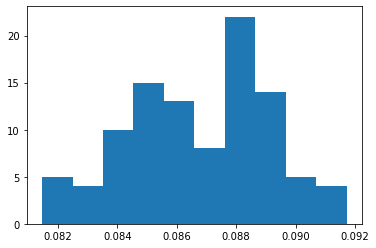

In [116]:
plt.hist(mse_bs)
plt.show()

In [117]:
 np.random.randint(0,10,10)

array([2, 8, 9, 5, 3, 5, 7, 0, 5, 6])